# Wasserstein GAN (WGAN) with Gradient Penalty (GP)

The original Wasserstein GAN leverages the Wasserstein distance to produce a value function that has better theoretical properties than the value function used in the original GAN paper. WGAN requires that the discriminator (aka the critic) lie within the space of 1-Lipschitz functions. The authors proposed the idea of weight clipping to achieve this constraint. Though weight clipping works, it can be a problematic way to enforce 1-Lipschitz constraint and can cause undesirable behavior, e.g. a very deep WGAN discriminator (critic) often fails to converge.

The WGAN-GP method proposes an alternative to weight clipping to ensure smooth training. Instead of clipping the weights, the authors proposed a "gradient penalty" by adding a loss term that keeps the L2 norm of the discriminator gradients close to 1.

https://keras.io/examples/generative/wgan_gp/

# Setup

In [348]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
from sklearn.metrics import r2_score, precision_recall_fscore_support, f1_score, ConfusionMatrixDisplay, confusion_matrix,precision_score, recall_score,accuracy_score 
from sklearn.metrics import roc_curve, auc,RocCurveDisplay, precision_recall_curve, PrecisionRecallDisplay
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import RFE
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB,BernoulliNB
from sklearn.preprocessing import MinMaxScaler,LabelEncoder,OneHotEncoder
import warnings
import seaborn as sns


# Load dataset


In [349]:
IMG_SHAPE = 41
BATCH_SIZE = 512


# traindata = pd.read_csv('NSL-KDD\KDDTrain+.txt', sep=",")
# print(traindata)
# print(traindata.shape)


col_names = ["duration","protocol_type","service","flag","src_bytes",
    "dst_bytes","land","wrong_fragment","urgent","hot","num_failed_logins",
    "logged_in","num_compromised","root_shell","su_attempted","num_root",
    "num_file_creations","num_shells","num_access_files","num_outbound_cmds",
    "is_host_login","is_guest_login","count","srv_count","serror_rate",
    "srv_serror_rate","rerror_rate","srv_rerror_rate","same_srv_rate",
    "diff_srv_rate","srv_diff_host_rate","dst_host_count","dst_host_srv_count",
    "dst_host_same_srv_rate","dst_host_diff_srv_rate","dst_host_same_src_port_rate",
    "dst_host_srv_diff_host_rate","dst_host_serror_rate","dst_host_srv_serror_rate",
    "dst_host_rerror_rate","dst_host_srv_rerror_rate","label", "difficulty_score"]
# print(col_names)
print(len(col_names))

traindata = pd.read_csv('NSL-KDD\KDDTrain+.txt', sep=",", header=None, names=col_names)
# traindata.info()
# print('train data')
# print(traindata)
# traindata.to_csv('NSL-KDD\KDDTrain+.csv')
testdata = pd.read_csv('NSL-KDD\KDDTest+.txt', sep=",",header=None, names=col_names)
# traindata.to_csv('NSL-KDD\KDDTest+.csv')
# print(testdata)

# first five rows
traindata.head(5)

43


,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label,difficulty_score
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal,20
1,0,udp,other,SF,146,0,0,0,0,0,...,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal,15
2,0,tcp,private,S0,0,0,0,0,0,0,...,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune,19
3,0,tcp,http,SF,232,8153,0,0,0,0,...,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal,21
4,0,tcp,http,SF,199,420,0,0,0,0,...,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal,21


In [350]:

# We have found out that feature difficulty_score is not needed for the model to learn intrusion. So we can drop this column
# Following this resource
# https://github.com/CynthiaKoopman/Network-Intrusion-Detection/blob/master/DecisionTree_IDS.ipynb
traindata = traindata.drop('difficulty_score', axis=1)
testdata = testdata.drop('difficulty_score', axis=1)
IMG_SHAPE -= 1
testdata.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label
0,0,tcp,private,REJ,0,0,0,0,0,0,...,10,0.04,0.06,0.00,0.00,0.0,0.0,1.00,1.00,neptune
1,0,tcp,private,REJ,0,0,0,0,0,0,...,1,0.00,0.06,0.00,0.00,0.0,0.0,1.00,1.00,neptune
2,2,tcp,ftp_data,SF,12983,0,0,0,0,0,...,86,0.61,0.04,0.61,0.02,0.0,0.0,0.00,0.00,normal
3,0,icmp,eco_i,SF,20,0,0,0,0,0,...,57,1.00,0.00,1.00,0.28,0.0,0.0,0.00,0.00,saint
4,1,tcp,telnet,RSTO,0,15,0,0,0,0,...,86,0.31,0.17,0.03,0.02,0.0,0.0,0.83,0.71,mscan


In [351]:
# Statistical Summary
traindata.describe()

# # Better visualization
# traindata.hist()



,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate
count,125973.00000,1.259730e+05,1.259730e+05,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,...,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000
mean,287.14465,4.556674e+04,1.977911e+04,0.000198,0.022687,0.000111,0.204409,0.001222,0.395736,0.279250,...,182.148945,115.653005,0.521242,0.082951,0.148379,0.032542,0.284452,0.278485,0.118832,0.120240
std,2604.51531,5.870331e+06,4.021269e+06,0.014086,0.253530,0.014366,2.149968,0.045239,0.489010,23.942042,...,99.206213,110.702741,0.448949,0.188922,0.308997,0.112564,0.444784,0.445669,0.306557,0.319459
min,0.00000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.00000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,82.000000,10.000000,0.050000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.00000,4.400000e+01,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,255.000000,63.000000,0.510000,0.020000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.00000,2.760000e+02,5.160000e+02,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,...,255.000000,255.000000,1.000000,0.070000,0.060000,0.020000,1.000000,1.000000,0.000000,0.000000
max,42908.00000,1.379964e+09,1.309937e+09,1.000000,3.000000,3.000000,77.000000,5.000000,1.000000,7479.000000,...,255.000000,255.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [352]:
# Label Distribution of Training and Test set
print('Label distribution Training set:')
print(traindata['label'].value_counts())
print()
print('Label distribution Test set:')
print(testdata['label'].value_counts())

Label distribution Training set:
normal             67343
neptune            41214
satan               3633
ipsweep             3599
portsweep           2931
smurf               2646
nmap                1493
back                 956
teardrop             892
warezclient          890
pod                  201
guess_passwd          53
buffer_overflow       30
warezmaster           20
land                  18
imap                  11
rootkit               10
loadmodule             9
ftp_write              8
multihop               7
phf                    4
perl                   3
spy                    2
Name: label, dtype: int64

Label distribution Test set:
normal             9711
neptune            4657
guess_passwd       1231
mscan               996
warezmaster         944
apache2             737
satan               735
processtable        685
smurf               665
back                359
snmpguess           331
saint               319
mailbomb            293
snmpgetattack       178


In [353]:
# # duration Distribution of Training and Test set
# print('duration distribution Training set:')
# print(traindata['duration'].value_counts())
# print()
# print('duration distribution Test set:')
# print(testdata['duration'].value_counts())

# Data preprocessing

In [354]:
# Identify categorical features

# colums that are categorical and not binary yet: protocol_type (column 2), service (column 3), flag (column 4).
# explore categorical features
print('Training set:')
for col_name in traindata.columns:
    if traindata[col_name].dtypes == 'object' :
        unique_cat = len(traindata[col_name].unique())
        print("Feature '{col_name}' has {unique_cat} categories".format(col_name=col_name, unique_cat=unique_cat))

# see how distributed the feature service is, it is evenly distributed and therefore we need to make dummies for all.
print('\nDistribution of categories in service:')
print(traindata['service'].value_counts().sort_values(ascending=False).head())

Training set:
Feature 'protocol_type' has 3 categories
Feature 'service' has 70 categories
Feature 'flag' has 11 categories
Feature 'label' has 23 categories

Distribution of categories in service:
http        40338
private     21853
domain_u     9043
smtp         7313
ftp_data     6860
Name: service, dtype: int64


In [355]:
# Test set
print('Test set:')
for col_name in testdata.columns:
    if testdata[col_name].dtypes == 'object' :
        unique_cat = len(testdata[col_name].unique())
        print("Feature '{col_name}' has {unique_cat} categories".format(col_name=col_name, unique_cat=unique_cat))

Test set:
Feature 'protocol_type' has 3 categories
Feature 'service' has 64 categories
Feature 'flag' has 11 categories
Feature 'label' has 38 categories



Conclusion: Need to make dummies for all categories as the distribution is fairly even. In total: 3+70+11=84 dummies.

Comparing the results shows that the Test set has fewer categories (6), these need to be added as empty columns.

# LabelEncoder

In [356]:
# Insert categorical features into a 2D numpy array
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
# insert code to get a list of categorical columns into a variable, categorical_columns
categorical_columns=['protocol_type', 'service', 'flag']

# Get the categorical values into a 2D numpy array
df_categorical_values = traindata[categorical_columns]
testdf_categorical_values = testdata[categorical_columns]
df_categorical_values.head()

,protocol_type,service,flag
0,tcp,ftp_data,SF
1,udp,other,SF
2,tcp,private,S0
3,tcp,http,SF
4,tcp,http,SF


Make column names for dummies


In [357]:
# protocol type
unique_protocol=sorted(traindata.protocol_type.unique())
string1 = 'Protocol_type_'
unique_protocol2=[string1 + x for x in unique_protocol]
# service
unique_service=sorted(traindata.service.unique())
string2 = 'service_'
unique_service2=[string2 + x for x in unique_service]
# flag
unique_flag=sorted(traindata.flag.unique())
string3 = 'flag_'
unique_flag2=[string3 + x for x in unique_flag]
# put together
dumcols=unique_protocol2 + unique_service2 + unique_flag2
print(dumcols)

#do same for test set
# Test set has fewer (70-64 = 6) categories for 'service'
unique_service_test=sorted(testdata.service.unique())
unique_service2_test=[string2 + x for x in unique_service_test]
testdumcols=unique_protocol2 + unique_service2_test + unique_flag2


['Protocol_type_icmp', 'Protocol_type_tcp', 'Protocol_type_udp', 'service_IRC', 'service_X11', 'service_Z39_50', 'service_aol', 'service_auth', 'service_bgp', 'service_courier', 'service_csnet_ns', 'service_ctf', 'service_daytime', 'service_discard', 'service_domain', 'service_domain_u', 'service_echo', 'service_eco_i', 'service_ecr_i', 'service_efs', 'service_exec', 'service_finger', 'service_ftp', 'service_ftp_data', 'service_gopher', 'service_harvest', 'service_hostnames', 'service_http', 'service_http_2784', 'service_http_443', 'service_http_8001', 'service_imap4', 'service_iso_tsap', 'service_klogin', 'service_kshell', 'service_ldap', 'service_link', 'service_login', 'service_mtp', 'service_name', 'service_netbios_dgm', 'service_netbios_ns', 'service_netbios_ssn', 'service_netstat', 'service_nnsp', 'service_nntp', 'service_ntp_u', 'service_other', 'service_pm_dump', 'service_pop_2', 'service_pop_3', 'service_printer', 'service_private', 'service_red_i', 'service_remote_job', 'serv

Transform categorical features into numbers using LabelEncoder()

In [358]:
df_categorical_values_enc=df_categorical_values.apply(LabelEncoder().fit_transform)
print(df_categorical_values_enc.head())
# test set
testdf_categorical_values_enc=testdf_categorical_values.apply(LabelEncoder().fit_transform)

   protocol_type  service  flag
0              1       20     9
1              2       44     9
2              1       49     5
3              1       24     9
4              1       24     9


One-Hot-Encoding


In [359]:
enc = OneHotEncoder()
df_categorical_values_encenc = enc.fit_transform(df_categorical_values_enc)
df_cat_data = pd.DataFrame(df_categorical_values_encenc.toarray(),columns=dumcols)
# test set
testdf_categorical_values_encenc = enc.fit_transform(testdf_categorical_values_enc)
testdf_cat_data = pd.DataFrame(testdf_categorical_values_encenc.toarray(),columns=testdumcols)

df_cat_data.head()

,Protocol_type_icmp,Protocol_type_tcp,Protocol_type_udp,service_IRC,service_X11,service_Z39_50,service_aol,service_auth,service_bgp,service_courier,...,flag_REJ,flag_RSTO,flag_RSTOS0,flag_RSTR,flag_S0,flag_S1,flag_S2,flag_S3,flag_SF,flag_SH
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


Add 6 missing categories from train set to test set


In [360]:
trainservice=traindata['service'].tolist()
testservice= testdata['service'].tolist()
difference=list(set(trainservice) - set(testservice))
string = 'service_'
difference=[string + x for x in difference]
difference

['service_harvest',
 'service_http_8001',
 'service_http_2784',
 'service_red_i',
 'service_aol',
 'service_urh_i']

In [361]:
for col in difference:
    testdf_cat_data[col] = 0

testdf_cat_data.shape

(22544, 84)

Join encoded categorical dataframe with the non-categorical dataframe

In [362]:
newdf=traindata.join(df_cat_data)
newdf.drop('flag', axis=1, inplace=True)
newdf.drop('protocol_type', axis=1, inplace=True)
newdf.drop('service', axis=1, inplace=True)
# test data
newdf_test=testdata.join(testdf_cat_data)
newdf_test.drop('flag', axis=1, inplace=True)
newdf_test.drop('protocol_type', axis=1, inplace=True)
newdf_test.drop('service', axis=1, inplace=True)
print(newdf.shape)
print(newdf_test.shape)

(125973, 123)
(22544, 123)


In [363]:
traindata = newdf
print(traindata.shape)
print(traindata.head())
testdata = newdf_test
print(testdata.shape)
# print(testdata.head())


(125973, 123)
   duration  src_bytes  dst_bytes  land  wrong_fragment  urgent  hot  \
0         0        491          0     0               0       0    0   
1         0        146          0     0               0       0    0   
2         0          0          0     0               0       0    0   
3         0        232       8153     0               0       0    0   
4         0        199        420     0               0       0    0   

   num_failed_logins  logged_in  num_compromised  ...  flag_REJ  flag_RSTO  \
0                  0          0                0  ...       0.0        0.0   
1                  0          0                0  ...       0.0        0.0   
2                  0          0                0  ...       0.0        0.0   
3                  0          1                0  ...       0.0        0.0   
4                  0          1                0  ...       0.0        0.0   

   flag_RSTOS0  flag_RSTR  flag_S0  flag_S1  flag_S2  flag_S3  flag_SF  \
0         

In [364]:
# # for the sake of simplicity deleting the categorical features from the dataset at first 
# for del_col in categorical_columns:
#     traindata = traindata.drop(del_col, axis=1)
#     testdata = testdata.drop(del_col, axis=1)
#     IMG_SHAPE -= 1


# traindata.head()
testdata.head()

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,flag_S2,flag_S3,flag_SF,flag_SH,service_harvest,service_http_8001,service_http_2784,service_red_i,service_aol,service_urh_i
0,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0,0,0,0,0,0
2,2,12983,0,0,0,0,0,0,0,0,...,0.0,0.0,1.0,0.0,0,0,0,0,0,0
3,0,20,0,0,0,0,0,0,0,0,...,0.0,0.0,1.0,0.0,0,0,0,0,0,0
4,1,0,15,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0,0,0,0,0,0


In [365]:
traindata.columns

Index(['duration', 'src_bytes', 'dst_bytes', 'land', 'wrong_fragment',
       'urgent', 'hot', 'num_failed_logins', 'logged_in', 'num_compromised',
       ...
       'flag_REJ', 'flag_RSTO', 'flag_RSTOS0', 'flag_RSTR', 'flag_S0',
       'flag_S1', 'flag_S2', 'flag_S3', 'flag_SF', 'flag_SH'],
      dtype='object', length=123)

In [366]:
# fixing the sequence
column_list = list(traindata.columns)
# print(column_list)
column_list.remove('label')
# print(column_list)
column_list.append('label')
print(column_list)

['duration', 'src_bytes', 'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot', 'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell', 'su_attempted', 'num_root', 'num_file_creations', 'num_shells', 'num_access_files', 'num_outbound_cmds', 'is_host_login', 'is_guest_login', 'count', 'srv_count', 'serror_rate', 'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count', 'dst_host_srv_count', 'dst_host_same_srv_rate', 'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate', 'dst_host_serror_rate', 'dst_host_srv_serror_rate', 'dst_host_rerror_rate', 'dst_host_srv_rerror_rate', 'Protocol_type_icmp', 'Protocol_type_tcp', 'Protocol_type_udp', 'service_IRC', 'service_X11', 'service_Z39_50', 'service_aol', 'service_auth', 'service_bgp', 'service_courier', 'service_csnet_ns', 'service_ctf', 'service_daytime', 'service_discard', 'service_domain', 'service_domain_u', 'service_echo', 'se

In [367]:
traindata = traindata[[x for x in column_list]]
print(traindata.head())

testdata = testdata[[x for x in column_list]]
print(testdata.head())


   duration  src_bytes  dst_bytes  land  wrong_fragment  urgent  hot  \
0         0        491          0     0               0       0    0   
1         0        146          0     0               0       0    0   
2         0          0          0     0               0       0    0   
3         0        232       8153     0               0       0    0   
4         0        199        420     0               0       0    0   

   num_failed_logins  logged_in  num_compromised  ...  flag_RSTO  flag_RSTOS0  \
0                  0          0                0  ...        0.0          0.0   
1                  0          0                0  ...        0.0          0.0   
2                  0          0                0  ...        0.0          0.0   
3                  0          1                0  ...        0.0          0.0   
4                  0          1                0  ...        0.0          0.0   

   flag_RSTR  flag_S0  flag_S1  flag_S2  flag_S3  flag_SF  flag_SH    label  
0 

In [368]:
print(traindata.columns)

Index(['duration', 'src_bytes', 'dst_bytes', 'land', 'wrong_fragment',
       'urgent', 'hot', 'num_failed_logins', 'logged_in', 'num_compromised',
       ...
       'flag_RSTO', 'flag_RSTOS0', 'flag_RSTR', 'flag_S0', 'flag_S1',
       'flag_S2', 'flag_S3', 'flag_SF', 'flag_SH', 'label'],
      dtype='object', length=123)


# Correlation matrix

C:\Users\shawo\AppData\Local\Temp\ipykernel_21708\2683742872.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = traindata.corr(method = 'spearman')


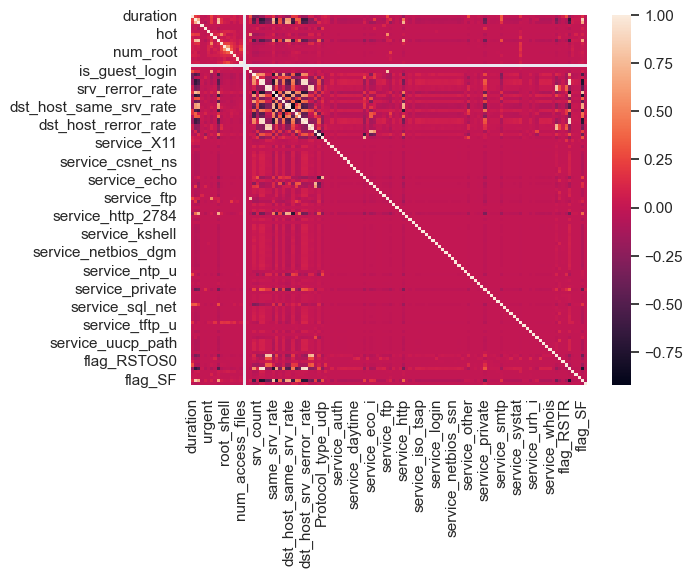

In [369]:
corr_matrix = traindata.corr(method = 'spearman')
# print(corr_matrix)
sns.heatmap(corr_matrix, annot=False)
plt.show()

In [370]:
# We have found out that feature 'num_outbound_cmds' is always zero. So we can drop this column

traindata = traindata.drop('num_outbound_cmds', axis=1)
testdata = testdata.drop('num_outbound_cmds', axis=1)

In [371]:
# # Convert correlation matrix to 1-D Series and sort
# corr_matrix  = traindata.corr(method = 'spearman')
# sorted_mat = corr_matrix.unstack().sort_values()

# print(sorted_mat)

# Convert labels

In [372]:
traindata['label'] = traindata['label'].replace('normal', 0)
traindata['label'] = traindata['label'].astype(bool).astype(int)
print(traindata['label'])

testdata['label'] = testdata['label'].replace('normal', 0)
testdata['label'] = testdata['label'].astype(bool).astype(int)
print(testdata['label'])

0         0
1         0
2         1
3         0
4         0
         ..
125968    1
125969    0
125970    0
125971    1
125972    0
Name: label, Length: 125973, dtype: int32
0        1
1        1
2        0
3        1
4        1
        ..
22539    0
22540    0
22541    1
22542    0
22543    1
Name: label, Length: 22544, dtype: int32


In [373]:
# traindata.to_csv('train.csv')
# testdata.to_csv('test.csv')

# Plotting data for visualization

<AxesSubplot: xlabel='label', ylabel='srv_rerror_rate'>

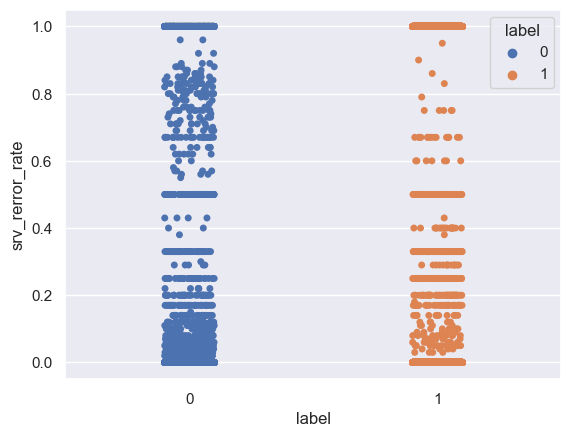

In [374]:
sns.stripplot(x="label", y="srv_rerror_rate", hue = "label", data=traindata,  jitter=0.1)

In [375]:
## too long - time consuming
# sns.pairplot(traindata.sample(1000), hue = 'label')

dst_host_srv_serror_rate
43
[0.   1.   0.03 0.1  0.2  0.25 0.08 0.11 0.33 0.43 0.5  0.07 0.14 0.62
 0.09 0.81 0.06 0.17 0.05 0.75 0.8  0.29 0.12 0.04 0.02 0.71 0.79 0.83
 0.56 0.67 0.84 0.4  0.64 0.74 0.38 0.85 0.15 0.69 0.6  0.73 0.76 0.57
 0.86 0.92 0.82 0.18 0.22 0.78 0.77 0.88 0.96 0.7  0.9  0.72 0.01 0.89
 0.55 0.87 0.95 0.13 0.58 0.3 ]


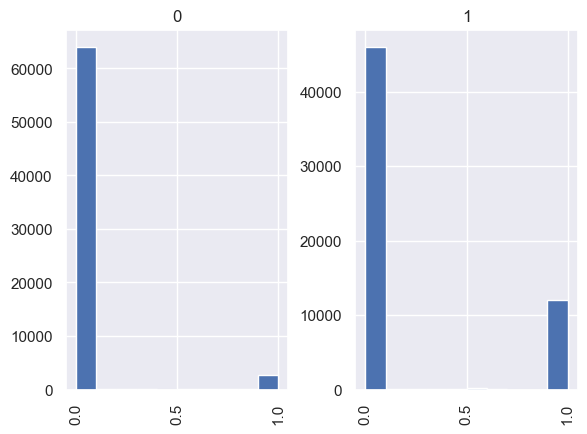

In [376]:
print(col_names[38])
print(len(col_names))
column_name = 'srv_rerror_rate'  
# ning_categorical= ['is_guest_login' , 'land' ,'is_host_login', 'logged_in', 'root_shell']
traindata.hist(column= column_name, by= 'label')
print(traindata[column_name].unique())

In [377]:
# plt.figure()
# for i in traindata.columns:
#     if i != 'label':
#         print(i)
#         ax = traindata.plot.hist(column = i, by='label')
#         plt.show()
# # traindata.groupby('label').hist()
# # traindata.groupby(['label']).hist()

# Feature Engineering

In [378]:
# ------------------ MI score and ANOVA score --------------------

In [379]:
# # takes too much space and time
# for col in traindata.columns[:-1]:
    
#     plt.figure(figsize=(5,3))
#     sns.histplot(traindata.sample(1000), x = col, hue = 'label')

#     plt.show()

In [380]:
# # sns.displot(data=traindata, kind='hist', hue=traindata['label'],
# #                 multiple='dodge', common_bins=False, facet_kws={'sharey': False, 'sharex': False})

# plot_df = pd.melt(traindata, value_vars=[i for i in traindata.columns and i != 'label'], var_name='melt')

# sns.displot(data=plot_df, hue='melt',x='value',
#             kind="kde", fill=True, legend=False, height=5, aspect=1.6, 
#             cut=0, bw_adjust=1)

# Splitting test and train set 

In [381]:
# ------------ Load your own data----

# training_size = 10000
# training_size = 125973
training_size = traindata.shape[0] 
print('Training size is:', training_size)

train_images = traindata.iloc[:training_size,:-1]
# print('features')
# print(train_images)

train_labels = traindata.iloc[:training_size, -1] 
# print('\n targets')
# print(train_labels)


test_images = testdata.iloc[:,:-1]
print('features')
print(test_images)
test_labels = testdata.iloc[:, -1]
print('\n targets')
print(test_labels)

#------------------------



Training size is: 125973
features
       duration  src_bytes  dst_bytes  land  wrong_fragment  urgent  hot  \
0             0          0          0     0               0       0    0   
1             0          0          0     0               0       0    0   
2             2      12983          0     0               0       0    0   
3             0         20          0     0               0       0    0   
4             1          0         15     0               0       0    0   
...         ...        ...        ...   ...             ...     ...  ...   
22539         0        794        333     0               0       0    0   
22540         0        317        938     0               0       0    0   
22541         0      54540       8314     0               0       0    2   
22542         0         42         42     0               0       0    0   
22543         0          0          0     0               0       0    0   

       num_failed_logins  logged_in  num_compromised 

In [382]:
# traindata['label'].value_counts()

Reshaping the dataframe

In [383]:
# # # Reshape each sample to (28, 28, 1) and normalize the pixel values in the [-1, 1] range
# # print(IMG_SHAPE)
# # print(train_images)
# train_images = train_images.values.reshape(-1, IMG_SHAPE)
# test_images = test_images.values.reshape(-1, IMG_SHAPE)

Scaling the Dataframe

In [384]:
# if there is any negative data in the dataframe
myScaler = MinMaxScaler()
# Since there is no negative data in the dataframe - but porforms poor
# myScaler = StandardScaler()
train_images = myScaler.fit_transform(train_images)
test_images = myScaler.transform(test_images)

In [385]:
# # just checking everything - works fine
# df_describe = pd.DataFrame(train_images)

# print('Summary stat is: ')
# newTempdf = df_describe.describe()
# newTempdf.to_csv('just check std.csv')


#  Applying PCA function to get the noise dimension

In [386]:
pca = PCA()
x_pca = pca.fit_transform(train_images)
x_test = pca.transform(test_images)
# pd.DataFrame(x_pca).hist()
explained_variance = pca.explained_variance_ratio_
n_components = pca.n_components_
# print(explained_variance)
print(n_components)


121


In [387]:
x_pca.shape

(125973, 121)

In [388]:
# let us get the number of features to get a fixed percentage of variance in the data
variance_boundary = 0.90
sum = 0
# optimized_feature_no = 0 
for i in range(x_pca.shape[1]):
    sum += pca.explained_variance_ratio_[i]
    print(i+1, sum)
    if sum > variance_boundary:
        optimized_feature_no = i
        print('Latent Dimension should be at least: ', optimized_feature_no)
        break

1 0.41249065058803414
2 0.5689978108336289
3 0.678416199882829
4 0.7291505249720466
5 0.7702112230251381
6 0.7984332225167954
7 0.8211206915142922
8 0.8409187962936262
9 0.8558974375684666
10 0.8696831346393937
11 0.8810240278737497
12 0.8907691908993959
13 0.8975306522503291
14 0.9041010523103806
Latent Dimension should be at least:  13


Since the output is optimized_feature_no = 14. We need the noise dimension to be 14 at least

# Using Supervised Machine learning for comparison

In [389]:
# X_train, y_train = train_images, train_labels
# X_test,y_test = test_images, test_labels

X_train, y_train = x_pca, train_labels
X_test,y_test = x_test, test_labels

# # with optimized_feature_no
# X_train, y_train = x_pca[:, :optimized_feature_no], train_labels
# X_test,y_test = x_test[:,:optimized_feature_no], test_labels




In [390]:
X_train.shape
# # pd.DataFrame(X_train).to_csv("see x train.csv")

(125973, 121)

In [391]:
# To store results of models, we create a dictionary
# result_dict_train = {}

"""
result_dict_test = {}

models = {'Naïve Bayes Classifier': GaussianNB, 'Bernoulli Naïve Bayes Classifier': BernoulliNB, 'Decision Tree Classifier' : DecisionTreeClassifier, 'KNN Classifier': KNeighborsClassifier,
        'Random Forest Classifier': RandomForestClassifier,'Logistic Regression': LogisticRegression}
        # , 'Support Vector Classifier': SVC, 'Linear Regression': LinearRegression }

        
# for keys, values in sorted(models.items()):
#     print(keys +" is "+ values)

warnings.filterwarnings("ignore")

# for name, model in models.items():
#     print(name +" is "+ model)


for model_name, model_function in models.items():
    comparison_metrics  = []
    print(model_name +' is running')
    try:
        model = model_function(random_state = 42)
    except:
        if(model_name=='Logistic Regression'):
            model = model_function(solver='lbfgs', max_iter=1000)
        model = model_function()
    accuracies = cross_val_score(model, X_train, y_train, cv=5)
    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)


    #Obtain accuracy
    train_accuracy = np.mean(accuracies)
    print("Train Score:",train_accuracy)
    comparison_metrics.append(train_accuracy)
    test_accuracy = model.score(X_test,y_test)
    comparison_metrics.append(test_accuracy)
    print("Test Score:",test_accuracy)
    # alternative can be - same result
    # print("Test Accuracy Score:",accuracy_score(y_test,y_pred)) 

    test_r2_score = r2_score(y_test, y_pred)
    print("R2 Score:",test_r2_score)
    comparison_metrics.append(test_r2_score)

    per_class_precision = precision_score( y_test, y_pred, average=None)
    print('Per-class precision score:', per_class_precision)
    comparison_metrics.append(per_class_precision[0])
    comparison_metrics.append(per_class_precision[1])
    # print('Recall: %.3f' % recall_score(y_test, y_pred))
    test_recall = recall_score(y_test, y_pred)
    print('Recall: ', test_recall)
    comparison_metrics.append(test_recall)

    test_f1_score = f1_score(y_test, y_pred, average='micro')

    print("Test Score (F1 - micro):",test_f1_score)
    # print("Test Score (F1 - macro):",f1_score(y_test, y_pred, average='macro'))
    # print("Test Score (F1 - weighted):",f1_score(y_test, y_pred, average='weighted'))
    comparison_metrics.append(test_f1_score)


    # Calculate the confusion matrix
    #
    conf_matrix = confusion_matrix(y_true=y_test, y_pred=y_pred)
    # determining the metrics
    TN = conf_matrix[0][0]
    # print("True Negative", TN)
    FN = conf_matrix[1][0]
    # print("False Negative", FN)
    TP = conf_matrix[1][1]
    print("True Positive", TP)
    FP = conf_matrix[0][1]
    print("False Positive", FP)
    # Sensitivity, hit rate, recall, or true positive rate
    TPR = TP/(TP+FN)
    # Specificity or true negative rate
    TNR = TN/(TN+FP) 
    # Precision or positive predictive value
    PPV = TP/(TP+FP)
    # Negative predictive value
    NPV = TN/(TN+FN)
    # Fall out or false positive rate
    FPR = FP/(FP+TN)
    
    # False negative rate
    FNR = FN/(TP+FN)
    # False discovery rate
    FDR = FP/(TP+FP)

    print('False Positive Rate is: ', FPR)
    comparison_metrics.append(FPR)
    #
    # Print the confusion matrix using Matplotlib
    #
    fig, ax = plt.subplots(figsize=(5, 5))
    ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
    for i in range(conf_matrix.shape[0]):
        for j in range(conf_matrix.shape[1]):
            ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
    
    plt.xlabel('Predictions', fontsize=18)
    plt.ylabel('Actuals', fontsize=18)
    plt.title('Confusion Matrix', fontsize=18)
    # plt.show()



    #Store results in the dictionaries
    
    result_dict_test[model_name] = comparison_metrics
    

"""

'\nresult_dict_test = {}\n\nmodels = {\'Naïve Bayes Classifier\': GaussianNB, \'Bernoulli Naïve Bayes Classifier\': BernoulliNB, \'Decision Tree Classifier\' : DecisionTreeClassifier, \'KNN Classifier\': KNeighborsClassifier,\n        \'Random Forest Classifier\': RandomForestClassifier,\'Logistic Regression\': LogisticRegression}\n        # , \'Support Vector Classifier\': SVC, \'Linear Regression\': LinearRegression }\n\n        \n# for keys, values in sorted(models.items()):\n#     print(keys +" is "+ values)\n\nwarnings.filterwarnings("ignore")\n\n# for name, model in models.items():\n#     print(name +" is "+ model)\n\n\nfor model_name, model_function in models.items():\n    comparison_metrics  = []\n    print(model_name +\' is running\')\n    try:\n        model = model_function(random_state = 42)\n    except:\n        if(model_name==\'Logistic Regression\'):\n            model = model_function(solver=\'lbfgs\', max_iter=1000)\n        model = model_function()\n    accuracies = c

In [392]:
# Compare Accuracy Scores
"""""
df_result_test = pd.DataFrame.from_dict(result_dict_test,orient = "index", columns=[ 'train_accuracy', 'test_r2_score', 
                'accuracy', 'benign_precision', 'anomaly_precision', 'recall', 'f1_score', 'FPR'])
print(df_result_test)
# df_result_test.to_csv('Test set metrics.csv')

# df_result_test = pd.DataFrame.from_dict(result_dict_test,orient = "index",columns=["Score"])
# df_result_test

# Display the accuracy scores
fig,ax = plt.subplots(1,2,figsize=(10,5))
sns.barplot(x = df_result_test.index,y = df_result_test.recall,ax = ax[0])
sns.barplot(x = df_result_test.index,y = df_result_test.FPR,ax = ax[1])
ax[0].set_xticklabels(df_result_test.index,rotation = 85)
ax[1].set_xticklabels(df_result_test.index,rotation = 85)

# plt.savefig('Checking model recall and FPR after PCA.png')
plt.show()

fig,ax = plt.subplots(1,2,figsize=(10,5))
sns.barplot(x = df_result_test.index,y = df_result_test.benign_precision,ax = ax[0])
sns.barplot(x = df_result_test.index,y = df_result_test.anomaly_precision,ax = ax[1])
ax[0].set_xticklabels(df_result_test.index,rotation = 85)
ax[1].set_xticklabels(df_result_test.index,rotation = 85)
# plt.show()
# plt.savefig('Checking model precision after PCA.png')
plt.show()
"""

'""\ndf_result_test = pd.DataFrame.from_dict(result_dict_test,orient = "index", columns=[ \'train_accuracy\', \'test_r2_score\', \n                \'accuracy\', \'benign_precision\', \'anomaly_precision\', \'recall\', \'f1_score\', \'FPR\'])\nprint(df_result_test)\n# df_result_test.to_csv(\'Test set metrics.csv\')\n\n# df_result_test = pd.DataFrame.from_dict(result_dict_test,orient = "index",columns=["Score"])\n# df_result_test\n\n# Display the accuracy scores\nfig,ax = plt.subplots(1,2,figsize=(10,5))\nsns.barplot(x = df_result_test.index,y = df_result_test.recall,ax = ax[0])\nsns.barplot(x = df_result_test.index,y = df_result_test.FPR,ax = ax[1])\nax[0].set_xticklabels(df_result_test.index,rotation = 85)\nax[1].set_xticklabels(df_result_test.index,rotation = 85)\n\n# plt.savefig(\'Checking model recall and FPR after PCA.png\')\nplt.show()\n\nfig,ax = plt.subplots(1,2,figsize=(10,5))\nsns.barplot(x = df_result_test.index,y = df_result_test.benign_precision,ax = ax[0])\nsns.barplot(x =

In [393]:
# tham

# Sub op issue

In [394]:
# # converting 1D to 2D image
# print(train_images.shape)
# print(train_images.dtypes)
# train_images = train_images.astype('float32')
# print(train_images.dtypes)
# # train_images = np.asarray(train_images).astype(np.float32).reshape(-1, 37)
# # train_images.shape

In [395]:
# print(test_images.shape)
# # test_images = np.asarray(test_images).astype(np.float32).reshape(-1, 37)
# test_images = test_images.astype('float32')
# print(test_images.dtypes)
# # test_images.shape

In [396]:
# -------------------------------------------            Working with fashion dataset



# INPUT_SHAPE = 784
# BATCH_SIZE = 512

# # Size of the noise vector
# noise_dim = 128

# # loading Mnist data----
# fashion_mnist = keras.datasets.fashion_mnist
# (train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

# # Reshape each sample to (28, 28, 1) and normalize the pixel values in the [-1, 1] range
# train_images = train_images.reshape(-1, 784)
# test_images = test_images.reshape(-1, 784)


# scaler = MinMaxScaler()
# train_images = scaler.fit_transform(train_images)
# test_images = scaler.transform(test_images)

# Exporting to csv files
# traindata.to_csv('check train features.csv')
# testdata.to_csv('check test features.csv')

In [397]:
traindata.dtypes

duration            int64
src_bytes           int64
dst_bytes           int64
land                int64
wrong_fragment      int64
                   ...   
flag_S2           float64
flag_S3           float64
flag_SF           float64
flag_SH           float64
label               int32
Length: 122, dtype: object

## Create the discriminator (the critic in the original WGAN)


In [398]:
# feat_number = train_images.shape[1]
IMG_SHAPE = X_train.shape[1]
def build_discriminator():
    # IMG_SHAPE = train_images.shape[1]
    print('we got img shape :', IMG_SHAPE)
    d_model = keras.Sequential(
        [

            keras.Input(shape=(IMG_SHAPE,)),
            # layers.Dense(128, activation = 'relu'),
            layers.Dense(64, activation = 'relu'),
            layers.Dense(32, activation = 'relu'),
            layers.Dense(16, activation = 'relu'),
            layers.Dense(8, activation = 'relu'),
            # layers.Dense(1, activation = 'sigmoid')
            # for WGAN it should be linear
            layers.Dense(1, activation = 'linear')

            # keras.Input(shape=(INPUT_SHAPE,)),
            # layers.Dense(512, activation = 'relu'),
            # layers.Dense(128, activation = 'relu'),
            # layers.Dense(1, activation = 'linear')
            
        ],
        # name="discriminator",
    )
    d_model.summary()
    return d_model

# Create the generator

In [399]:
# Size of the noise vector
# noise_dim = 16
noise_dim = optimized_feature_no
# latent_dim = noise_dim
# latent_dim = optimized_feature_no
def build_generator():
    print("Latent Dimension is: ", noise_dim)
    g_model = keras.Sequential(
        [
            keras.Input(shape=(noise_dim,)),
            # layers.Dense(8, activation = 'relu'),
            # layers.Dense(16, activation = 'relu'),
            layers.Dense(32, activation = 'relu'),
            layers.Dense(64, activation = 'relu'),
            # layers.Dense(128, activation = 'relu'),
            layers.Dense(IMG_SHAPE, activation = 'sigmoid')


            # layers.Dense(256, activation = 'relu'),
            # layers.Dense(512, activation = 'relu'),
            # layers.Dense(INPUT_SHAPE, activation = 'linear')

        ],
        # name="generator",
    )
    g_model.summary()
    return g_model

# Override train_step


In [400]:
class WGAN(keras.Model):
    def __init__(self, latent_dim, discriminator, generator, discriminator_extra_steps=3, gp_weight=10.0,):
        super(WGAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.d_steps = discriminator_extra_steps
        self.gp_weight = gp_weight

    def compile(self, d_optimizer, g_optimizer, d_loss_fn, g_loss_fn):
        super(WGAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.d_loss_fn = d_loss_fn
        self.g_loss_fn = g_loss_fn
        # self.d_loss_metric = keras.metrics.Mean(name="d_loss")
        # self.g_loss_metric = keras.metrics.Mean(name="g_loss")

    # @property
    # def metrics(self):
    #     return [self.d_loss_metric, self.g_loss_metric]

    def gradient_penalty(self, batch_size, real_images, fake_images):
        """Calculates the gradient penalty.

        This loss is calculated on an interpolated image
        and added to the discriminator loss.
        """
        # Get the interpolated image
        # alpha = tf.random.normal([batch_size], 0.0, 1.0)
        # print(batch_size)
        alpha = tf.random.normal([batch_size,1], 0.0, 1.0)
        # print(alpha)
        diff = fake_images - real_images
        interpolated = real_images + alpha * diff

        with tf.GradientTape() as gp_tape:
            gp_tape.watch(interpolated)
            # 1. Get the discriminator output for this interpolated image.
            pred = self.discriminator(interpolated, training=True)

        # 2. Calculate the gradients w.r.t to this interpolated image.
        grads = gp_tape.gradient(pred, [interpolated])[0]
        # 3. Calculate the norm of the gradients.
        # norm = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=[1, 2, 3]))
        norm = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=[1]))
        gp = tf.reduce_mean((norm - 1.0) ** 2)
        return gp

    def train_step(self, real_images):
        if isinstance(real_images, tuple):
            # real_images = real_images[0]
            real_images = real_images[0]

        # Get the batch size
        batch_size = tf.shape(real_images)[0]

        # For each batch, we are going to perform the
        # following steps as laid out in the original paper:
        # 1. Train the generator and get the generator loss
        # 2. Train the discriminator and get the discriminator loss
        # 3. Calculate the gradient penalty
        # 4. Multiply this gradient penalty with a constant weight factor
        # 5. Add the gradient penalty to the discriminator loss
        # 6. Return the generator and discriminator losses as a loss dictionary

        # Train the discriminator first. The original paper recommends training
        # the discriminator for `x` more steps (typically 5) as compared to
        # one step of the generator. Here we will train it for 3 extra steps
        # as compared to 5 to reduce the training time.
        for i in range(self.d_steps):
            # Get the latent vector
            random_latent_vectors = tf.random.normal(
                shape=(batch_size, self.latent_dim)
            )
            with tf.GradientTape() as tape:
                # Generate fake images from the latent vector
                fake_images = self.generator(random_latent_vectors, training=True)
                # Get the logits for the fake images
                fake_logits = self.discriminator(fake_images, training=True)
                # Get the logits for the real images
                real_logits = self.discriminator(real_images, training=True)

                # Calculate the discriminator loss using the fake and real image logits
                d_cost = self.d_loss_fn(real_img=real_logits, fake_img=fake_logits)
                # Calculate the gradient penalty
                gp = self.gradient_penalty(batch_size, real_images, fake_images)
                # Add the gradient penalty to the original discriminator loss
                d_loss = d_cost + gp * self.gp_weight

            # Get the gradients w.r.t the discriminator loss
            d_gradient = tape.gradient(d_loss, self.discriminator.trainable_variables)
            # Update the weights of the discriminator using the discriminator optimizer
            self.d_optimizer.apply_gradients(
                zip(d_gradient, self.discriminator.trainable_variables)
            )

        # Train the generator
        # Get the latent vector
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
        with tf.GradientTape() as tape:
            # Generate fake images using the generator
            generated_images = self.generator(random_latent_vectors, training=True)
            # Get the discriminator logits for fake images
            gen_img_logits = self.discriminator(generated_images, training=True)
            # Calculate the generator loss
            g_loss = self.g_loss_fn(gen_img_logits)

        # Get the gradients w.r.t the generator loss
        gen_gradient = tape.gradient(g_loss, self.generator.trainable_variables)
        # Update the weights of the generator using the generator optimizer
        self.g_optimizer.apply_gradients(
            zip(gen_gradient, self.generator.trainable_variables)
        )
        return {"d_loss": d_loss, "g_loss": g_loss}


    # # Define the loss functions for the discriminator,
    # # which should be (fake_loss - real_loss).
    # # We will add the gradient penalty later to this loss function.
    # def discriminator_loss(real_img, fake_img):
    #     real_loss = tf.reduce_mean(real_img)
    #     fake_loss = tf.reduce_mean(fake_img)
    #     return  fake_loss - real_loss


    # # Define the loss functions for the generator.
    # def generator_loss(fake_img):
    #     return -tf.reduce_mean(fake_img)

    # Deleting (Calling destructor)
    def __del__(self):
        print('Destructor called, GAN deleted.')

# Train the end-to-end model


In [401]:
# epochs = int(input('Enter epoch (>=200):'))

epochs = 200
# epochs = 100

# Define the loss functions for the discriminator,
# which should be (fake_loss - real_loss).
# We will add the gradient penalty later to this loss function.
def discriminator_loss(real_img, fake_img):
    real_loss = tf.reduce_mean(real_img)
    fake_loss = tf.reduce_mean(fake_img)
    return  fake_loss - real_loss


# Define the loss functions for the generator.
def generator_loss(fake_img):
    return -tf.reduce_mean(fake_img)


def getWGANModel():
    
    # Define the loss functions for the discriminator,
    # which should be (fake_loss - real_loss).
    # We will add the gradient penalty later to this loss function.
    def discriminator_loss(real_img, fake_img):
        real_loss = tf.reduce_mean(real_img)
        fake_loss = tf.reduce_mean(fake_img)
        return  fake_loss - real_loss


    # Define the loss functions for the generator.
    def generator_loss(fake_img):
        return -tf.reduce_mean(fake_img)

    # Get the wgan model
    wgan = WGAN(
        discriminator=build_discriminator(),
        generator=build_generator(),
        latent_dim=noise_dim,
        discriminator_extra_steps=3,
    )

    # Compile the wgan model
    wgan.compile(
        d_optimizer=keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5, beta_2=0.9),
        g_optimizer=keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5, beta_2=0.9),
        g_loss_fn=generator_loss,
        d_loss_fn=discriminator_loss
    )
    
    return wgan


# Creating WGAN Objects for generating benign and anomaly data separately

In [402]:
# WGAN for benign data generation purpose

wgan_benign = getWGANModel()


we got img shape : 121
Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_64 (Dense)            (None, 64)                7808      
                                                                 
 dense_65 (Dense)            (None, 32)                2080      
                                                                 
 dense_66 (Dense)            (None, 16)                528       
                                                                 
 dense_67 (Dense)            (None, 8)                 136       
                                                                 
 dense_68 (Dense)            (None, 1)                 9         
                                                                 
Total params: 10,561
Trainable params: 10,561
Non-trainable params: 0
_________________________________________________________________
Latent Dimension is:  13
M

In [403]:
# plt.hist(train_images[:,:])

In [404]:
train_images[train_labels == 0].shape + train_images[train_labels == 1].shape

(67343, 121, 58630, 121)

In [405]:
# Start training with benign data
print("------------------------------- Benign GAN is training ----------------------------")
history_benign = wgan_benign.fit(train_images[train_labels == 0], batch_size=BATCH_SIZE, epochs=epochs)
# history_benign = wgan_benign.fit(X_train[y_train == 0], batch_size=BATCH_SIZE, epochs=epochs)

------------------------------- Benign GAN is training ----------------------------
Epoch 1/200
132/132 [==============================] - 3s 6ms/step - d_loss: -3.4289 - g_loss: 4.5510
Epoch 2/200
132/132 [==============================] - 1s 6ms/step - d_loss: -3.3419 - g_loss: 2.9383
Epoch 3/200
132/132 [==============================] - 1s 6ms/step - d_loss: -1.2486 - g_loss: 0.4673
Epoch 4/200
132/132 [==============================] - 1s 6ms/step - d_loss: -0.9297 - g_loss: 0.2505
Epoch 5/200
132/132 [==============================] - 1s 6ms/step - d_loss: -0.8123 - g_loss: 0.2387
Epoch 6/200
132/132 [==============================] - 1s 6ms/step - d_loss: -0.6526 - g_loss: 0.1998
Epoch 7/200
132/132 [==============================] - 1s 6ms/step - d_loss: -0.5208 - g_loss: 0.0979
Epoch 8/200
132/132 [==============================] - 1s 6ms/step - d_loss: -0.4316 - g_loss: -0.0398
Epoch 9/200
132/132 [==============================] - 1s 6ms/step - d_loss: -0.3703 - g_loss: -0.1

In [406]:
# history_benign.history

In [407]:
# test_labels == y_test

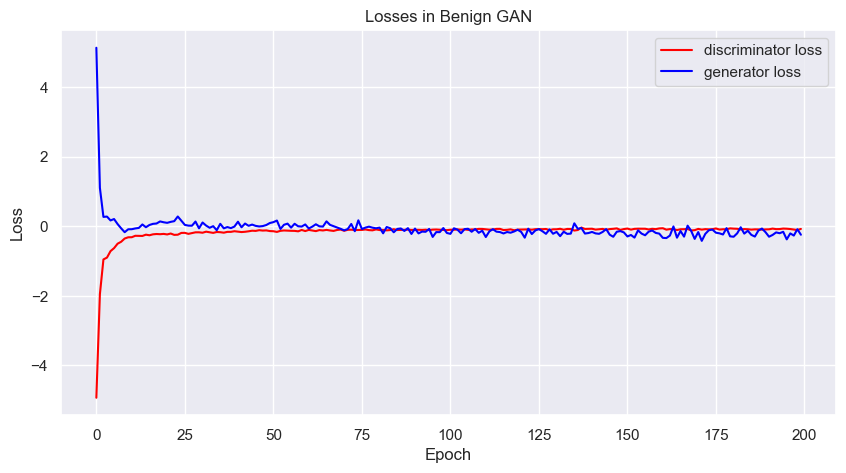

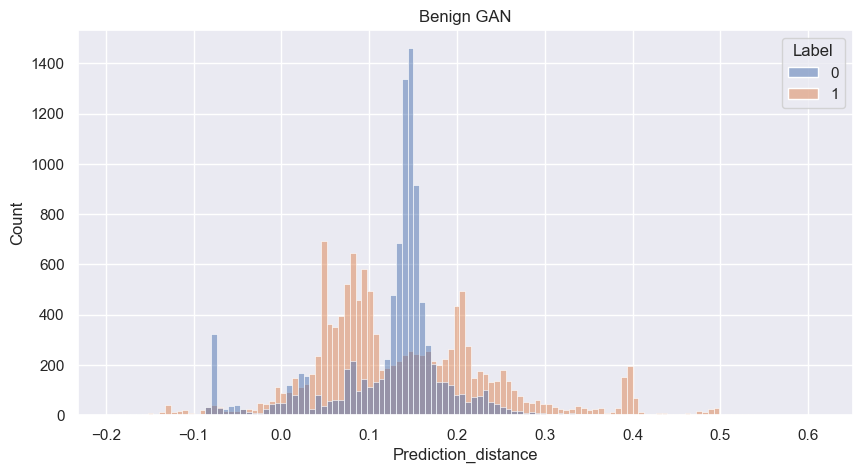

In [408]:
fig, ax = plt.subplots(figsize = (10,5))

plt.plot(history_benign.history['d_loss'], color = "red", label='discriminator loss')
plt.plot(history_benign.history['g_loss'], color = "blue", label='generator loss')
ax.set_title("Losses in Benign GAN")
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.legend()
plt.show



# y_pred_benign = wgan_benign.discriminator(test_images)
y_pred_benign = wgan_benign.discriminator(X_test)
y_pred_benign = np.array(y_pred_benign).flatten()
prediction_df_benign = pd.DataFrame(y_pred_benign,columns=['Prediction_distance'])
# print(prediction_df_benign.head())
prediction_df_benign['Label'] = test_labels # test_labels == y_test
prediction_df_benign['LabelName'] = ['normal' if x == 0 else 'anomaly' for x in prediction_df_benign['Label']]

# prediction_df_benign['LabelName'] = prediction_df_benign['Label'].replace( 0, 'normal')
# prediction_df_benign['LabelName'] = prediction_df_benign['Label'].replace( 1, 'anomaly')

# print(prediction_df_benign.head())
# prediction_df_benign.to_csv('prediction_df_benign.csv')

# plt.figure()
fig, ax = plt.subplots(figsize = (10,5))
ax.set_title('Benign GAN')
sns.histplot(prediction_df_benign, x = 'Prediction_distance', hue = 'Label')
plt.show()



In [409]:
# scale Pandas DataFrame columns 
minMaxScaler = MinMaxScaler()
# dfTest[['A', 'B']] = scaler.fit_transform(dfTest[['A', 'B']])
prediction_df_benign[['Prediction_distance']] = minMaxScaler.fit_transform(prediction_df_benign[['Prediction_distance']])

print(prediction_df_benign.head())

# prediction_df_benign.describe()

   Prediction_distance  Label LabelName
0             0.350672      1   anomaly
1             0.338134      1   anomaly
2             0.342715      0    normal
3             0.495443      1   anomaly
4             0.338111      1   anomaly


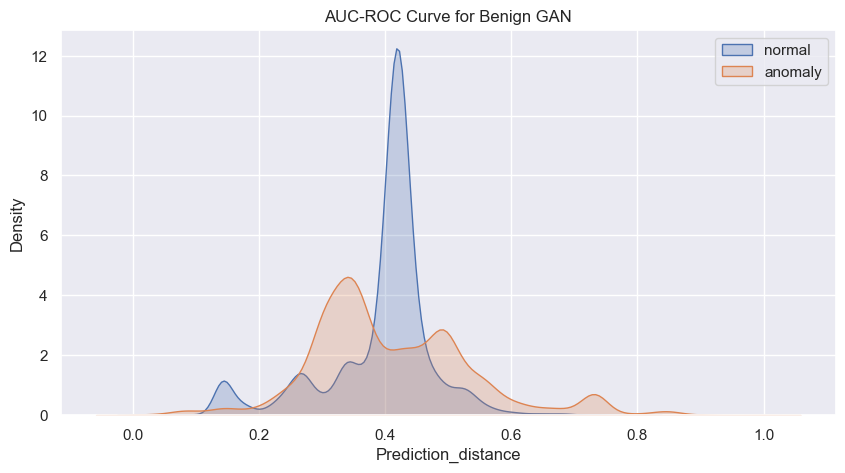

In [410]:
fig, ax = plt.subplots(figsize = (10,5))
ax.set_title('AUC-ROC Curve for Benign GAN')
sns.kdeplot(prediction_df_benign[prediction_df_benign['LabelName'] =='normal' ]['Prediction_distance'], fill = True,  label = 'normal' )
sns.kdeplot(prediction_df_benign[prediction_df_benign['LabelName'] =='anomaly' ]['Prediction_distance'],  fill = True, label = 'anomaly' )

ax.set_xlabel('Prediction_distance')
# plt.savefig('AUC-ROC Curve for Benign GAN after PCA.png')
plt.legend()
plt.show()



AUC-ROC Curve to understand the separation

In [411]:
label_array = prediction_df_benign['Label'].to_numpy()
prediction_array = prediction_df_benign['Prediction_distance'].to_numpy()
fpr, tpr, thresholds = roc_curve(label_array, prediction_array , pos_label=None)
auc_score = auc(fpr, tpr)
print("%0.4f" % auc_score)

0.4937


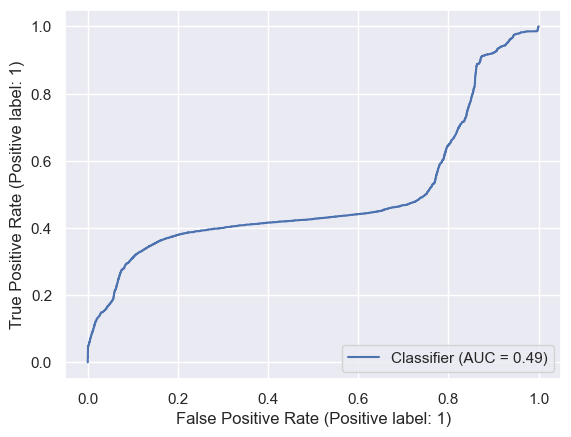

In [412]:
# pos_label=1 means focusing on anomaly
roc_display =  RocCurveDisplay.from_predictions(label_array, prediction_array,pos_label=1)
# # pos_label=0 means focusing on normal 
# RocCurveDisplay.from_predictions(label_array, prediction_array,pos_label=0)

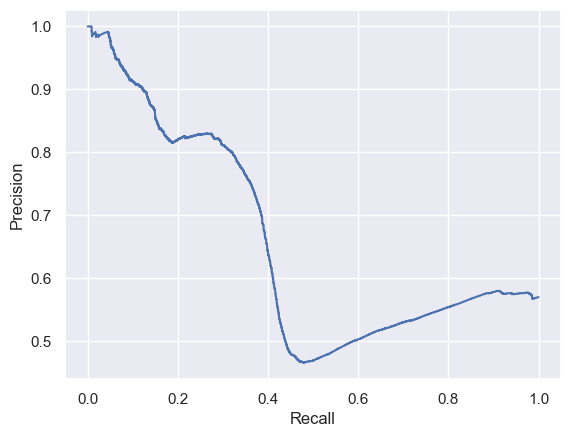

In [413]:
# Ploting the PR curve
# pos_label=1 means focusing on anomaly
prec, recall, _ = precision_recall_curve(label_array, prediction_array, pos_label=1)
pr_display = PrecisionRecallDisplay(precision=prec, recall=recall).plot()


In [414]:
# # pos_label=0 means focusing on normal 
# prec, recall, _ = precision_recall_curve(label_array, prediction_array, pos_label=0)
# pr_display = PrecisionRecallDisplay(precision=prec, recall=recall).plot()

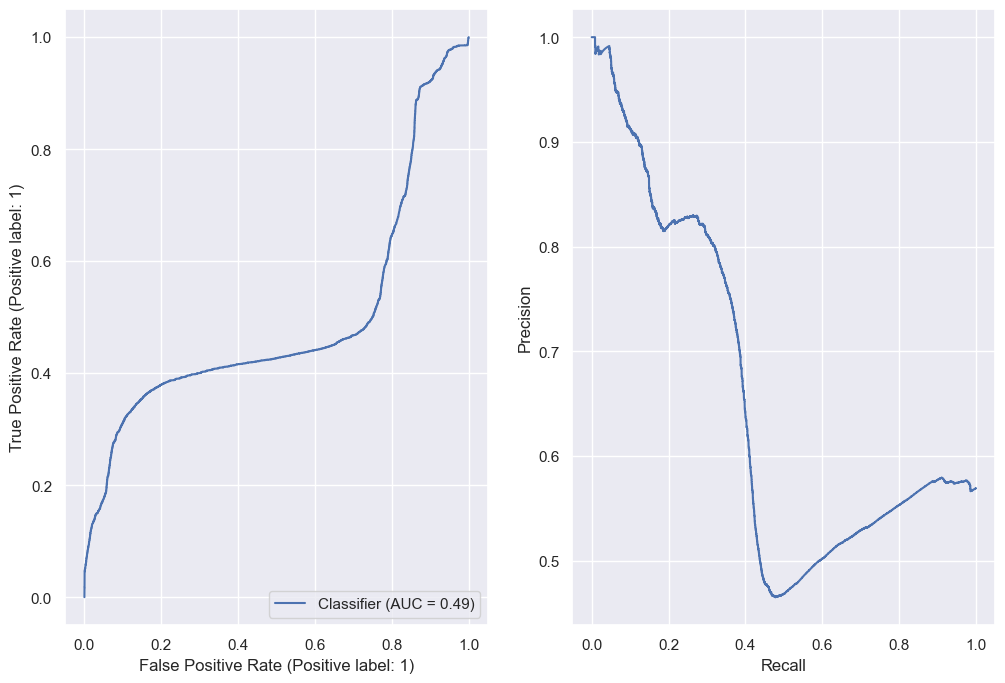

In [415]:
# Combining the display objects into a single plot

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))

roc_display.plot(ax=ax1)
pr_display.plot(ax=ax2)
plt.show()

In [416]:
fpr, tpr, thresholds 

(array([0.        , 0.        , 0.        , ..., 0.99989702, 1.        ,
        1.        ]),
 array([0.00000000e+00, 7.79241019e-05, 8.72749942e-03, ...,
        9.99688304e-01, 9.99688304e-01, 1.00000000e+00]),
 array([2.        , 0.99999994, 0.7985946 , ..., 0.01921989, 0.01639554,
        0.        ], dtype=float32))

In [417]:
fpr.size

7494

In [418]:
# Using the destructor to get rid of everything
save_wgan_begign = wgan_benign

# save_wgan_begign.save('/tmp/model')
# loaded_model = tf.keras.models.load_model('/tmp/model')
# save_wgan_begign.build((IMG_SHAPE,) )
# print(save_wgan_begign.summary())

# print(wgan_benign.get_weights())



In [419]:
# checkpoint

In [420]:
# print(save_wgan_begign.get_weights())
del wgan_benign
# print('benign GAN is to be deleted')

In [421]:
# after deletion weight should be stored at the saved variable
# print(wgan_benign.get_weights())
print(save_wgan_begign.get_weights())

[array([[ 3.00413705e-02, -5.09426324e-03,  5.84777221e-02, ...,
        -4.25767861e-02,  1.26305856e-02, -1.59477349e-02],
       [-2.43015736e-02, -2.60069408e-03, -7.64046272e-05, ...,
         3.14044603e-03, -2.44096126e-02,  1.21049918e-04],
       [-4.55769338e-02,  1.25936074e-02, -1.12450635e-02, ...,
         1.27346939e-04, -2.98812035e-02,  2.67086108e-03],
       ...,
       [-3.30006448e-03, -1.31270304e-01,  1.99935809e-02, ...,
        -5.89452265e-03,  1.29865261e-03, -8.19203183e-02],
       [ 3.26895006e-02,  1.35167167e-01, -7.72047937e-02, ...,
         2.85784155e-02, -2.82577634e-01,  1.61056727e-01],
       [-5.98877855e-03,  3.53846848e-02,  2.18349136e-03, ...,
         3.95099074e-03, -6.22932613e-02, -1.44665893e-02]], dtype=float32), array([-0.11713789,  0.0931795 , -0.4447052 , -0.16557084,  0.08027436,
       -0.6177231 ,  0.13364913,  0.10736552,  0.15072681, -0.28621626,
        0.01982452, -0.07858562, -0.2391827 ,  0.08191592,  0.14707105,
        0.

# Creating the anomaly generation WGAN 

In [422]:
wgan_anomaly = getWGANModel()


we got img shape : 121
Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_72 (Dense)            (None, 64)                7808      
                                                                 
 dense_73 (Dense)            (None, 32)                2080      
                                                                 
 dense_74 (Dense)            (None, 16)                528       
                                                                 
 dense_75 (Dense)            (None, 8)                 136       
                                                                 
 dense_76 (Dense)            (None, 1)                 9         
                                                                 
Total params: 10,561
Trainable params: 10,561
Non-trainable params: 0
_________________________________________________________________
Latent Dimension is:  13
M

In [423]:
# Start training with anomaly data 
print("------------------------------- Anomaly GAN is training ----------------------------")
history_anomaly = wgan_anomaly.fit(train_images[train_labels == 1], batch_size=BATCH_SIZE, epochs=epochs )
# history_anomaly = wgan_anomaly.fit(X_train[y_train == 1], batch_size=BATCH_SIZE, epochs=epochs)

------------------------------- Anomaly GAN is training ----------------------------
Epoch 1/200
Destructor called, GAN deleted.
115/115 [==============================] - 3s 6ms/step - d_loss: -3.4627 - g_loss: 3.8365
Epoch 2/200
115/115 [==============================] - 1s 6ms/step - d_loss: -4.2485 - g_loss: 3.7422
Epoch 3/200
115/115 [==============================] - 1s 7ms/step - d_loss: -2.1180 - g_loss: 0.7731
Epoch 4/200
115/115 [==============================] - 1s 6ms/step - d_loss: -1.4284 - g_loss: -0.1834
Epoch 5/200
115/115 [==============================] - 1s 7ms/step - d_loss: -1.2367 - g_loss: -0.4981
Epoch 6/200
115/115 [==============================] - 1s 6ms/step - d_loss: -1.0265 - g_loss: -0.6870
Epoch 7/200
115/115 [==============================] - 1s 6ms/step - d_loss: -0.8570 - g_loss: -0.7286
Epoch 8/200
115/115 [==============================] - 1s 7ms/step - d_loss: -0.7324 - g_loss: -0.6729
Epoch 9/200
115/115 [==============================] - 1s 6ms/

In [424]:
# history_anomaly.history

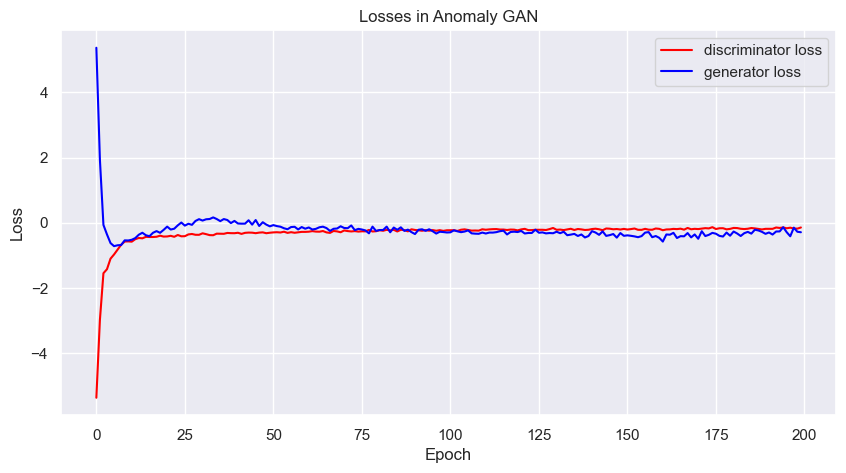

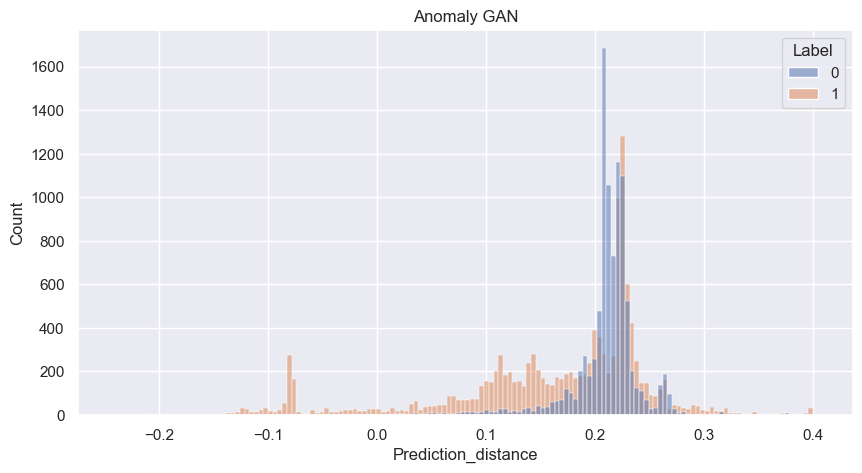

In [425]:
fig, ax = plt.subplots(figsize = (10,5))

plt.plot(history_anomaly.history['d_loss'], color = "red", label='discriminator loss')
plt.plot(history_anomaly.history['g_loss'], color = "blue", label='generator loss')
ax.set_title("Losses in Anomaly GAN")
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.legend()
plt.show


# y_pred_anomaly = wgan_anomaly.discriminator(test_images)
y_pred_anomaly = -wgan_anomaly.discriminator(X_test)

y_pred_anomaly = np.array(y_pred_anomaly).flatten()
prediction_df_anomaly = pd.DataFrame(y_pred_anomaly,columns=['Prediction_distance'])
# print(prediction_df_anomaly.head())
# test_labels == y_test
prediction_df_anomaly['Label'] = test_labels # test_labels == y_test
prediction_df_anomaly['LabelName'] =  ['normal' if x == 0 else 'anomaly' for x in prediction_df_anomaly['Label']]


# print(prediction_df_benign.head())
# prediction_df_anomaly.to_csv('prediction_df_anomaly.csv')


# plt.figure()
fig, ax = plt.subplots(figsize = (10,5))
ax.set_title('Anomaly GAN')
sns.histplot(prediction_df_anomaly, x = 'Prediction_distance', hue = 'Label')
plt.show()



In [426]:
# scale Pandas DataFrame columns 
minMaxScaler = MinMaxScaler()
# dfTest[['A', 'B']] = scaler.fit_transform(dfTest[['A', 'B']])
prediction_df_anomaly[['Prediction_distance']] = minMaxScaler.fit_transform(prediction_df_anomaly[['Prediction_distance']])

print(prediction_df_anomaly.head())

# prediction_df_benign.describe()

   Prediction_distance  Label LabelName
0             0.718695      1   anomaly
1             0.721857      1   anomaly
2             0.720267      0    normal
3             0.619208      1   anomaly
4             0.470852      1   anomaly


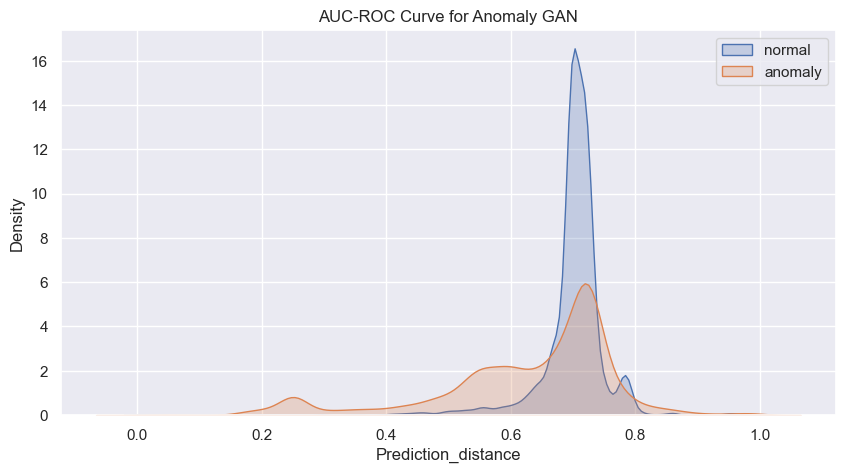

In [427]:
fig, ax = plt.subplots(figsize = (10,5))
ax.set_title('AUC-ROC Curve for Anomaly GAN')
sns.kdeplot(prediction_df_anomaly[prediction_df_anomaly['LabelName'] =='normal' ]['Prediction_distance'], label = 'normal' , fill = True, ax =ax)
sns.kdeplot(prediction_df_anomaly[prediction_df_anomaly['LabelName'] =='anomaly' ]['Prediction_distance'], label = 'anomaly' , fill = True, ax =ax)
ax.set_xlabel('Prediction_distance')
plt.legend()
# plt.savefig('AUC-ROC Curve for Anomaly GAN after PCA.png')
plt.show()

In [428]:
label_array = prediction_df_anomaly['Label'].to_numpy()
prediction_array = prediction_df_anomaly['Prediction_distance'].to_numpy()
fpr, tpr, thresholds = roc_curve(label_array, prediction_array , pos_label=None)
auc_score = auc(fpr, tpr)
print("%0.4f" % auc_score)

0.3708


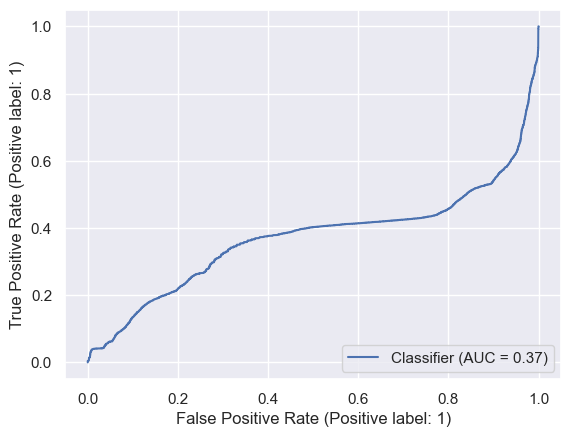

In [429]:
# pos_label=1 means focusing on anomaly
# pos_label=None gets the best result
roc_display =  RocCurveDisplay.from_predictions(label_array, prediction_array,pos_label=None)
# # pos_label=0 means focusing on normal 
# RocCurveDisplay.from_predictions(label_array, prediction_array,pos_label=0)

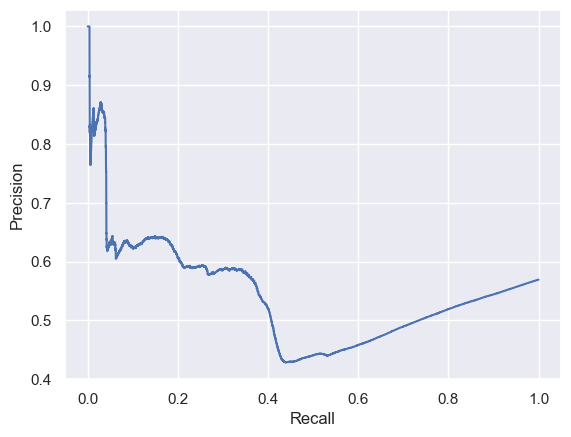

In [430]:
# Ploting the PR curve
# pos_label=1 means focusing on anomaly
prec, recall, _ = precision_recall_curve(label_array, prediction_array, pos_label=1)
pr_display = PrecisionRecallDisplay(precision=prec, recall=recall).plot()

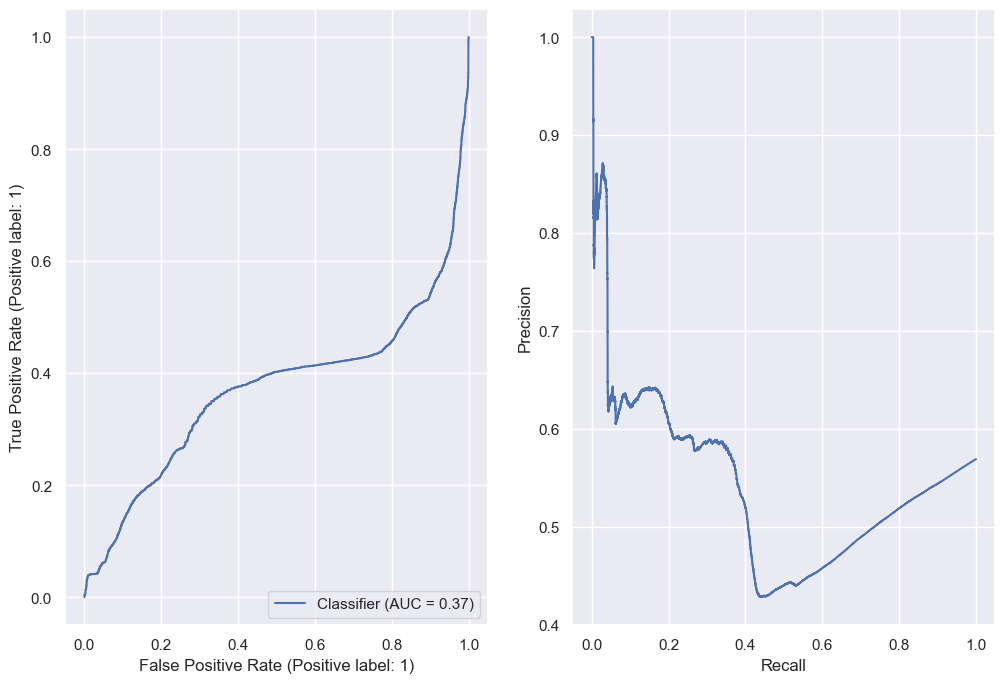

In [431]:
# Combining the display objects into a single plot¶

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))

roc_display.plot(ax=ax1)
pr_display.plot(ax=ax2)
plt.show()

In [432]:
save_wgan_anomaly = wgan_anomaly
# print(wgan_anomaly.get_weights())
del wgan_anomaly
# print('Anomaly GAN is to be deleted') 


Saved 2 models

In [433]:
# print(wgan_anomaly.get_weights())
print(save_wgan_anomaly.get_weights())

[array([[-0.00709567, -0.06408462,  0.04409756, ...,  0.02732598,
        -0.00280572,  0.07829548],
       [-0.00938605,  0.00540466,  0.0324531 , ...,  0.00496848,
         0.00332806, -0.00311142],
       [-0.01352066,  0.0023116 ,  0.03333696, ..., -0.00139441,
         0.00213088,  0.00416651],
       ...,
       [-0.02781458,  0.01908694,  0.0009444 , ..., -0.00806915,
         0.00982031,  0.01214097],
       [-0.26957205, -0.03487106, -0.03183911, ..., -0.08302749,
         0.13705777,  0.04427826],
       [-0.02035235, -0.02499699,  0.02769237, ..., -0.01042916,
        -0.01810287, -0.10911838]], dtype=float32), array([-0.04371669,  0.0935859 ,  0.28220975, -0.34620962, -0.01258761,
       -0.1031853 , -0.6015103 ,  0.02540085, -0.0773143 , -0.17260894,
        0.2973888 ,  0.18384512,  0.16364591,  0.19863066, -0.12379505,
        0.03764794,  0.17227465, -0.01921268, -0.05684759,  0.09149353,
        0.07965147, -0.12428979, -0.5895252 , -0.0101781 ,  0.13707362,
        0.

In [434]:
# checking if the weights are changed or not 
save_wgan_anomaly.get_weights()

[array([[-0.00709567, -0.06408462,  0.04409756, ...,  0.02732598,
         -0.00280572,  0.07829548],
        [-0.00938605,  0.00540466,  0.0324531 , ...,  0.00496848,
          0.00332806, -0.00311142],
        [-0.01352066,  0.0023116 ,  0.03333696, ..., -0.00139441,
          0.00213088,  0.00416651],
        ...,
        [-0.02781458,  0.01908694,  0.0009444 , ..., -0.00806915,
          0.00982031,  0.01214097],
        [-0.26957205, -0.03487106, -0.03183911, ..., -0.08302749,
          0.13705777,  0.04427826],
        [-0.02035235, -0.02499699,  0.02769237, ..., -0.01042916,
         -0.01810287, -0.10911838]], dtype=float32),
 array([-0.04371669,  0.0935859 ,  0.28220975, -0.34620962, -0.01258761,
        -0.1031853 , -0.6015103 ,  0.02540085, -0.0773143 , -0.17260894,
         0.2973888 ,  0.18384512,  0.16364591,  0.19863066, -0.12379505,
         0.03764794,  0.17227465, -0.01921268, -0.05684759,  0.09149353,
         0.07965147, -0.12428979, -0.5895252 , -0.0101781 ,  0.137

In [435]:
save_wgan_begign.get_weights() 

[array([[ 3.00413705e-02, -5.09426324e-03,  5.84777221e-02, ...,
         -4.25767861e-02,  1.26305856e-02, -1.59477349e-02],
        [-2.43015736e-02, -2.60069408e-03, -7.64046272e-05, ...,
          3.14044603e-03, -2.44096126e-02,  1.21049918e-04],
        [-4.55769338e-02,  1.25936074e-02, -1.12450635e-02, ...,
          1.27346939e-04, -2.98812035e-02,  2.67086108e-03],
        ...,
        [-3.30006448e-03, -1.31270304e-01,  1.99935809e-02, ...,
         -5.89452265e-03,  1.29865261e-03, -8.19203183e-02],
        [ 3.26895006e-02,  1.35167167e-01, -7.72047937e-02, ...,
          2.85784155e-02, -2.82577634e-01,  1.61056727e-01],
        [-5.98877855e-03,  3.53846848e-02,  2.18349136e-03, ...,
          3.95099074e-03, -6.22932613e-02, -1.44665893e-02]], dtype=float32),
 array([-0.11713789,  0.0931795 , -0.4447052 , -0.16557084,  0.08027436,
        -0.6177231 ,  0.13364913,  0.10736552,  0.15072681, -0.28621626,
         0.01982452, -0.07858562, -0.2391827 ,  0.08191592,  0.14707

# Combining both GAN's result

In [436]:
test_labels 

0        1
1        1
2        0
3        1
4        1
        ..
22539    0
22540    0
22541    1
22542    0
22543    1
Name: label, Length: 22544, dtype: int32

In [460]:
prediction_df_combined = pd.DataFrame()
prediction_df_combined['LabelAnomaly'] = prediction_df_anomaly['Prediction_distance']
prediction_df_combined['LabelBenign'] = prediction_df_benign['Prediction_distance']
# test_labels == y_test
prediction_df_combined['ActualLabel']  = test_labels # test_labels == y_test
prediction_df_combined['ActualLabelName'] =  ['normal' if x == 0 else 'anomaly' for x in prediction_df_anomaly['Label']]
prediction_df_combined.head()


,LabelAnomaly,LabelBenign,ActualLabel,ActualLabelName
0,0.718695,0.350672,1,anomaly
1,0.721857,0.338134,1,anomaly
2,0.720267,0.342715,0,normal
3,0.619208,0.495443,1,anomaly
4,0.470852,0.338111,1,anomaly


In [468]:
import math
prediction_df_combined['LabelAnomaly'].apply(lambda x: float(x))
prediction_df_combined['LabelBenign'].apply(lambda x: float(x))
# prediction_df_combined['PredictedLabel']  = numpy.floor((prediction_df_combined['LabelAnomaly'].astype(float) + prediction_df_combined['LabelBenign'].astype(float))/2)
prediction_df_combined['PredictedLabel']  = (prediction_df_combined['LabelBenign']*1.5+prediction_df_combined['LabelAnomaly']*0.5 )/2
prediction_df_combined['PredictedLabel']  = [0 if x <= 0.5 else 1 for x in prediction_df_combined['PredictedLabel']]
prediction_df_combined

,LabelAnomaly,LabelBenign,ActualLabel,ActualLabelName,PredictedLabel
0,0.718695,0.350672,1,anomaly,0
1,0.721857,0.338134,1,anomaly,0
2,0.720267,0.342715,0,normal,0
3,0.619208,0.495443,1,anomaly,1
4,0.470852,0.338111,1,anomaly,0
...,...,...,...,...,...
22539,0.631999,0.430035,0,normal,0
22540,0.712284,0.439774,0,normal,1
22541,0.719821,0.447343,1,anomaly,1
22542,0.665567,0.343196,0,normal,0


In [469]:
acc_combined = accuracy_score(prediction_df_combined['ActualLabel'] , prediction_df_combined['PredictedLabel'] )
print('Combined accuracy', acc_combined)

Combined accuracy 0.5122870830376153


In [470]:
# prediction_df_combined['ActualLabel'].apply(lambda x: float(x))
# print(prediction_df_combined)
truth_table = prediction_df_combined['ActualLabel'] == prediction_df_combined['PredictedLabel'] 
print(truth_table)

count = 0 
for x in truth_table:
    if(x==True):
        count+=1
print("Got True:", count)
print("Got False:", prediction_df_combined.shape[0]-count)



0        False
1        False
2         True
3         True
4        False
         ...  
22539     True
22540    False
22541     True
22542     True
22543    False
Length: 22544, dtype: bool
Got True: 11549
Got False: 10995


In [471]:
prediction_df_combined.hist

<bound method hist_frame of        LabelAnomaly  LabelBenign  ActualLabel ActualLabelName  PredictedLabel
0          0.718695     0.350672            1         anomaly               0
1          0.721857     0.338134            1         anomaly               0
2          0.720267     0.342715            0          normal               0
3          0.619208     0.495443            1         anomaly               1
4          0.470852     0.338111            1         anomaly               0
...             ...          ...          ...             ...             ...
22539      0.631999     0.430035            0          normal               0
22540      0.712284     0.439774            0          normal               1
22541      0.719821     0.447343            1         anomaly               1
22542      0.665567     0.343196            0          normal               0
22543      0.614675     0.341471            1         anomaly               0

[22544 rows x 5 columns]>

<AxesSubplot: ylabel='Count'>

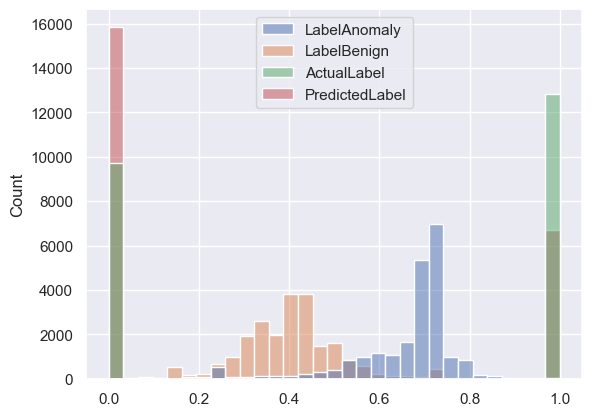

In [472]:
sns.histplot(data=prediction_df_combined)


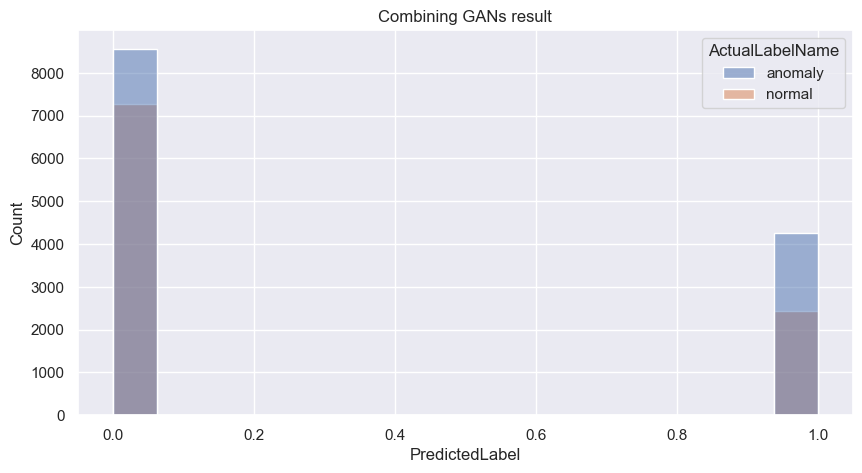

In [473]:
# Plot - work on this
# plt.figure()
fig, ax = plt.subplots(figsize = (10,5))
ax.set_title('Combining GANs result')
# sns.histplot(prediction_df_combined, x = 'LabelBenign', hue = 'ActualLabelName')
# sns.histplot(prediction_df_combined, x = 'LabelAnomaly', hue = 'ActualLabelName')
sns.histplot(prediction_df_combined, x = 'PredictedLabel', hue = 'ActualLabelName')
plt.show()




In [474]:
# sns.set(style="darkgrid")
# df = sns.load_dataset('tips')

# sns.boxplot(x="LabelBenign", y="LabelAnomaly", hue="PredictedLabel", data=prediction_df_combined, palette="Set1", width=0.5)
# plt.show()

In [475]:
y_pred_saved_benign = save_wgan_begign.discriminator(test_images)
y_pred_saved_benign = np.array(y_pred_saved_benign).flatten()
prediction_df_saved_benign = pd.DataFrame(y_pred_saved_benign,columns=['Prediction_error'])
print(prediction_df_saved_benign.head())
prediction_df_saved_benign['Label'] = test_labels
prediction_df_saved_benign

   Prediction_error
0          0.582835
1          0.601460
2          0.296265
3          1.102220
4          0.416506


,Prediction_error,Label
0,0.582835,1
1,0.601460,1
2,0.296265,0
3,1.102220,1
4,0.416506,1
...,...,...
22539,0.257843,0
22540,0.239675,0
22541,0.274899,1
22542,0.366704,0


In [476]:
# prediction_df_saved_benign.to_csv('prediction_df_saved_benign.csv')

In [477]:
y_pred_saved_anomaly = save_wgan_anomaly.discriminator(test_images)
y_pred_saved_anomaly = np.array(y_pred_saved_anomaly).flatten()
prediction_df_saved_anomaly = pd.DataFrame(y_pred_saved_anomaly,columns=['Prediction_error'])
print(prediction_df_saved_anomaly.head())
prediction_df_saved_anomaly['Label'] = test_labels
prediction_df_saved_anomaly

   Prediction_error
0          0.305881
1          0.295573
2         -0.046074
3          0.374025
4          0.805560


,Prediction_error,Label
0,0.305881,1
1,0.295573,1
2,-0.046074,0
3,0.374025,1
4,0.805560,1
...,...,...
22539,0.474414,0
22540,0.553772,0
22541,0.584357,1
22542,-0.014098,0


In [478]:
# prediction_df_saved_anomaly.to_csv('prediction_df_saved_anomaly.csv')

In [479]:
wgan_benign.discriminator(test_images[0:1])

NameError: name 'wgan_benign' is not defined

In [ ]:
x_fake = wgan_benign.generator(np.random.randn(10,128)).numpy()

In [ ]:
plt.imshow(x_fake[0])

In [ ]:
plt.imshow(x_fake[2])

In [ ]:
x_fake[0:1].shape

In [ ]:
x_fake[0].shape